#An Email Spam Filter using the Baye's Classifier

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Imports

In [10]:
!pip install wordcloud

from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

#nltk.download('all')
%matplotlib inline

##Constants (All the constant file paths)

In [11]:
exampleFile = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/practice_email.txt'

spam1 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam2 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/spam_2'

notSpam1 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
notSpam2 = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

spam = 1
notSpam = 0

vocabSize = 2500

dataJSON = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/exmail-test-data.json'
dataCSV = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/word-by-id.csv'

trainingDataFile = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/train-data.txt'
testingDataFile = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/test-data.txt'

whaleFile = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/whale-icon.png'
notSpamIcon = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
spamIcon = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

fontWordCloud = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
fontWordCloudLight = '/content/drive/MyDrive/Colab Notebooks/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'

##Reading Files

In [12]:
#Prints the complete file with all the information

stream = open(exampleFile, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [13]:
 #Prints only the body of the emails

isBody = False
mainList = []

stream = open(exampleFile, encoding='latin-1')

for line in stream:
    if isBody:
        mainList.append(line)
    elif line == '\n':
        isBody = True

stream.close()

finalBody = '\n'.join(mainList)
print(finalBody)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

##Extraction of all the EMail Bodies using generator functions

In [14]:
def emailBodyGen(path):

    for root, dirname, filenames in walk(path):
        for fileName in filenames:

            filepath = join(root, fileName)

            stream = open(filepath, encoding='latin-1')

            isBody = False
            mainList = []

            for line in stream:
                if isBody:
                    mainList.append(line)
                elif line == '\n':
                    isBody = True

            stream.close()

            finalBody = '\n'.join(mainList)
            
            yield fileName, finalBody

In [15]:
def dfFromDir(path, classify):
    
    rows = []
    rowNames = []

    for fileName, finalBody in emailBodyGen(path):
        rows.append({'CATEGORY': classify, 'MESSAGE': finalBody})
        rowNames.append(fileName)

    return pd.DataFrame(rows, index=rowNames) 

In [16]:
#Storing the spam emails in a spamEmails dataframe

spamEmails = dfFromDir(spam1, spam)
spamEmails = spamEmails.append(dfFromDir(spam2, spam))
spamEmails

,CATEGORY,MESSAGE
00126.e98e1ba87a38e0cceeb55f3b86dbd4dd,1,This is a multipart message in MIME format.\n\...
00423.bee32224fd8c9c8c06e2099d9c2adccd,1,Hello\n\n\n\nYou may have seen this business b...
00011.61816b9ad167657773a427d890d0468e,1,Cellular Phone Accessories All At Below Wholes...
00061.bec763248306fb3228141491856ed216,1,<!-- saved from url=3D(0022)http://internet.e-...
00393.13d4d84cb98ea19954f895c629520bf8,1,NEED Health Insurance? \n\n In addition to fea...
...,...,...
00500.87320162ab5b79f67978406cf909c3d1,1,As to\n\n\n\n\n\n\n\nWant to refinance?\n\n\n\...
00858.86651f55da5fa60fa633876354e0aead,1,---------------------\n\nNote: Your e-mail add...
00748.2b1fcd8621caf857e9ec0b08555ae5db,1,Long time no chat!\n\n\n\nHow have you been? I...
00299.ec4bd0c57a7bf6a5616beb2897aaed7b,1,"<html>\n\n<body bgcolor=3D""#003300"">\n\n<P ali..."


In [17]:
#Storing non spam emails in a notSpaEmails dataframe

notSpamEmails = dfFromDir(notSpam1, notSpam)
notSpamEmails = notSpamEmails.append(dfFromDir(notSpam2, notSpam))
notSpamEmails

,CATEGORY,MESSAGE
02029.d5a4d6426d7b98b1855162933e94e489,0,"URL: http://www.newsisfree.com/click/-5,829698..."
01237.2707518b441177e2f7e8497b63028981,0,Ahh sweet. Theres a reason for me to upgrade ...
01504.3a306a038f96c31abe2440db7f7c6806,0,jm@jmason.org (Justin Mason) writes:\n\n\n\n> ...
01820.96d981c2fc543b11a6dd277e7b510bf1,0,\n\nForwarded-by: Nev Dull <nev@sleepycat.com>...
01368.777aeabc5c7bd8e90b3c1cd33438b394,0,Update of /cvsroot/spamassassin/spamassassin/t...
...,...,...
00727.0e0eaefdffb144657140c062e5cc6697,0,There are so many good musician jokes.\n\n\n\n...
00848.a7399507608719a6c564442bb52f6bdf,0,Xander Blakley quotes a Russian joke in his te...
00549.703d3fc9f56814c467616f8aac31d22d,0,Not sure what you're asking. \n\n Content-...
00910.4b1bddb9bfc1cea936f0f8cae0cd097d,0,"On Friday, July 26, 2002, at 12:19 PM, James R..."


In [18]:
#Conacatenating the 2 dataframes to create a collusive dataframe for all the values

data = pd.concat([spamEmails, notSpamEmails])
data

,CATEGORY,MESSAGE
00126.e98e1ba87a38e0cceeb55f3b86dbd4dd,1,This is a multipart message in MIME format.\n\...
00423.bee32224fd8c9c8c06e2099d9c2adccd,1,Hello\n\n\n\nYou may have seen this business b...
00011.61816b9ad167657773a427d890d0468e,1,Cellular Phone Accessories All At Below Wholes...
00061.bec763248306fb3228141491856ed216,1,<!-- saved from url=3D(0022)http://internet.e-...
00393.13d4d84cb98ea19954f895c629520bf8,1,NEED Health Insurance? \n\n In addition to fea...
...,...,...
00727.0e0eaefdffb144657140c062e5cc6697,0,There are so many good musician jokes.\n\n\n\n...
00848.a7399507608719a6c564442bb52f6bdf,0,Xander Blakley quotes a Russian joke in his te...
00549.703d3fc9f56814c467616f8aac31d22d,0,Not sure what you're asking. \n\n Content-...
00910.4b1bddb9bfc1cea936f0f8cae0cd097d,0,"On Friday, July 26, 2002, at 12:19 PM, James R..."


##Data Cleaning and Checking for Missing Values

In [19]:
#Check if there are any missing values
data['MESSAGE'].isnull().values.any() #Returns true if there are any missing values

False

In [20]:
#Check if there are any empty emails with the string length of 0
(data.MESSAGE.str.len() == 0).any()

True

In [21]:
#Check how many entries have the string length of 0
(data.MESSAGE.str.len() == 0).sum()

3

In [22]:
#Getting the index of all the rows where the string length is 0
data[(data.MESSAGE.str.len() == 0)]

,CATEGORY,MESSAGE
cmds,1,
cmds,1,
cmds,0,


##Removing a and Renaming Entries from the Dataset

In [23]:
#cmds is  the ID of the column that refers to the null data

data.drop(['cmds'], inplace=True)

In [24]:
 #Adding Document IDs to track EMail IDs

documentIDs = range(0, len(data.index))
data['DOC_ID'] = documentIDs
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,This is a multipart message in MIME format.\n\...,00126.e98e1ba87a38e0cceeb55f3b86dbd4dd
1,1,Hello\n\n\n\nYou may have seen this business b...,00423.bee32224fd8c9c8c06e2099d9c2adccd
2,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e
3,1,<!-- saved from url=3D(0022)http://internet.e-...,00061.bec763248306fb3228141491856ed216
4,1,NEED Health Insurance? \n\n In addition to fea...,00393.13d4d84cb98ea19954f895c629520bf8
...,...,...,...
5783,0,There are so many good musician jokes.\n\n\n\n...,00727.0e0eaefdffb144657140c062e5cc6697
5784,0,Xander Blakley quotes a Russian joke in his te...,00848.a7399507608719a6c564442bb52f6bdf
5785,0,Not sure what you're asking. \n\n Content-...,00549.703d3fc9f56814c467616f8aac31d22d


##Saving the dataframe to the disk

In [25]:
data.to_json(dataJSON)

##Data Visualization through Pie Charts and Donut Charts

In [26]:
spamCounts = data.CATEGORY.value_counts()[0]
notSpamCounts = data.CATEGORY.value_counts()[1]

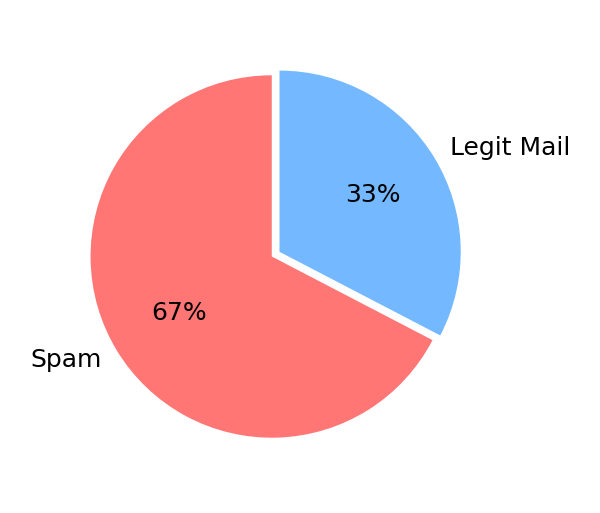

In [27]:
#Creating a pie chart

categoryNames = ['Spam', 'Legit Mail']
size = [spamCounts, notSpamCounts]
colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(size, labels=categoryNames, textprops={'fontsize': 6}, autopct='%1.0f%%', colors=colors, explode=[0, 0.05], startangle=90)
plt.show()

##Natural Language Processing

###Text Pre-Processing Techniques

In [28]:
#converting to lower case examples
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

###Downloading NLTK Resources

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package shakespeare to /root/nltk_data...
[nltk_data]   Unzipping corpora/shakespeare.zip.


True

###Tokenising: Segregating all the constituent words of the text.

In [32]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

###Removing Stop Words: Removing words like the, a, an, is, etc.

In [33]:
stopWords = set(stopwords.words('english'))

In [34]:
msg = 'All work and no play makes Jack a dull boy. TO be or not to be.'
words = word_tokenize(msg.lower())

filteredWords = []

for i in words:
    if i not in stopWords:
        filteredWords.append(i)

filteredWords

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

###Word stems and stemming

In [35]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filteredWords = []

for i in words:
    if i not in stopWords:
        stemmedWord = stemmer.stem(i)
        filteredWords.append(stemmedWord)

print(filteredWords)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.']


###Removing Punctuations

In [36]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be???'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filteredWords = []

for i in words:
    if i not in stopWords and i.isalpha():
        stemmedWord = stemmer.stem(i)
        filteredWords.append(stemmedWord)

print(filteredWords)

['work', 'play', 'make', 'jack', 'dull', 'boy']


###Removing HTML Tags

In [37]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
#soup.prettify() This method is used to print the html formatted text where the tags can be read in a better way.
soup.get_text()

'Cellular Phone Accessories All At Below Wholesale Prices!\n\n\n\nhttp://202.101.163.34:81/sites/merchant/sales/\n\n\n\nHands Free Ear Buds 1.99! \n\nPhone Holsters 1.98! \n\nBooster Antennas Only $0.99\n\nPhone Cases 1.98! \n\nCar Chargers 1.98! \n\nFace Plates As Low As 0.99! \n\nLithium Ion Batteries As Low As 6.94! \n\n\n\nhttp://202.101.163.34:81/sites/merchant/sales/\n\n\n\nClick Below For Accessories On All NOKIA, MOTOROLA LG, NEXTEL, \n\nSAMSUNG, QUALCOMM, ERICSSON, AUDIOVOX PHONES At Below \n\nWHOLESALE PRICES!\n\n\n\nhttp://202.101.163.34:81/sites/merchant/sales/\n\n\n\n***If You Need Assistance Please Call Us (732) 751-1457***\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\nTo be removed from future mailings please send your remove \n\nrequest to: removemenow68994@btamail.net.cn \n\nThank You and have a super day :)\n\n\n'

###Function for Email Processing

In [39]:
def cleanMessage (message, stemmer=PorterStemmer(), stopWords = set(stopwords.words('english'))):

    soup = BeautifulSoup(message, 'html.parser')
    wordsNoHTML = soup.get_text()  

    words = word_tokenize(wordsNoHTML.lower())
    filteredWords = []  

    for i in words:
        if i not in stopWords and i.isalpha():
            filteredWords.append(stemmer.stem(i))

    return filteredWords

In [40]:
cleanMessage(data.at[2, 'MESSAGE'])

['cellular',
 'phone',
 'accessori',
 'wholesal',
 'price',
 'http',
 'hand',
 'free',
 'ear',
 'bud',
 'phone',
 'holster',
 'booster',
 'antenna',
 'phone',
 'case',
 'car',
 'charger',
 'face',
 'plate',
 'low',
 'lithium',
 'ion',
 'batteri',
 'low',
 'http',
 'click',
 'accessori',
 'nokia',
 'motorola',
 'lg',
 'nextel',
 'samsung',
 'qualcomm',
 'ericsson',
 'audiovox',
 'phone',
 'wholesal',
 'price',
 'http',
 'need',
 'assist',
 'pleas',
 'call',
 'us',
 'remov',
 'futur',
 'mail',
 'pleas',
 'send',
 'remov',
 'request',
 'thank',
 'super',
 'day']

###Apply Cleaning and Tokenisation to all the messages

In [41]:
#Creating a massive series of all the messages cleaned and transformed

%%time

nestedList = data.MESSAGE.apply(cleanMessage)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 38.1 s, sys: 0 ns, total: 38.1 s
Wall time: 38.2 s


In [42]:
spamID = data[data.CATEGORY == 1].index
notSpamID = data[data.CATEGORY == 0].index

In [43]:
spamListNested = nestedList.loc[spamID]
notSpamListNested = nestedList.loc[notSpamID]

spamListNested.shape

(1889,)

In [44]:
finalSpamList = [item for sublist in spamListNested for item in sublist]
spamWords = pd.Series(finalSpamList).value_counts()

spamWords[:10] #First 10 most common words and freuency of their occurance

http      3092
email     3082
free      2551
click     2053
receiv    1978
list      1973
get       1899
pleas     1835
busi      1792
order     1741
dtype: int64

In [45]:
finalNotSpamList = [item for sublist in notSpamListNested for item in sublist]
notSpamWords = pd.Series(finalNotSpamList).value_counts()

notSpamWords[:10] #First 10 most common words and freuency of their occurance

http      7561
use       3626
list      2878
one       2368
get       2280
mail      2252
would     2003
like      1920
messag    1847
work      1795
dtype: int64

###Creating a Word Cloud

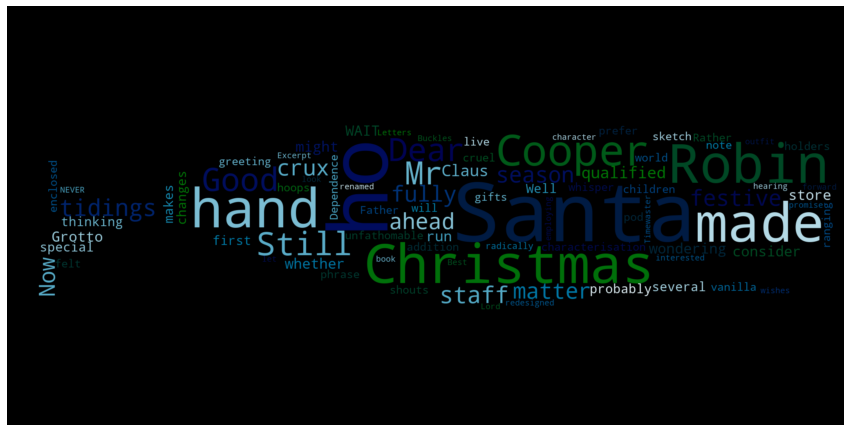

In [46]:
icon = Image.open(whaleFile)
imageMask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
imageMask.paste(icon, box=icon)

rgbArray = np.array(imageMask)

wordCloud = WordCloud(mask=rgbArray, colormap='ocean')

wordCloud.generate(finalBody)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###Word Cloud of Not Spam and Spam Messages

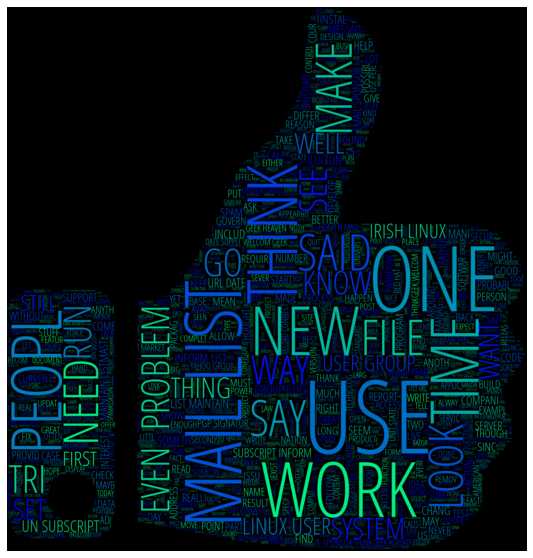

In [47]:
#NOT SPAM EMAILS

icon = Image.open(notSpamIcon)
imageMask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
imageMask.paste(icon, box=icon)

rgbArray = np.array(imageMask)

notSpamStr = ' '.join(finalNotSpamList)

wordCloud = WordCloud(mask=rgbArray, max_words=2000, colormap='winter', font_path=fontWordCloudLight, max_font_size=300)

wordCloud.generate(notSpamStr.upper())
plt.figure(figsize=(10, 10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

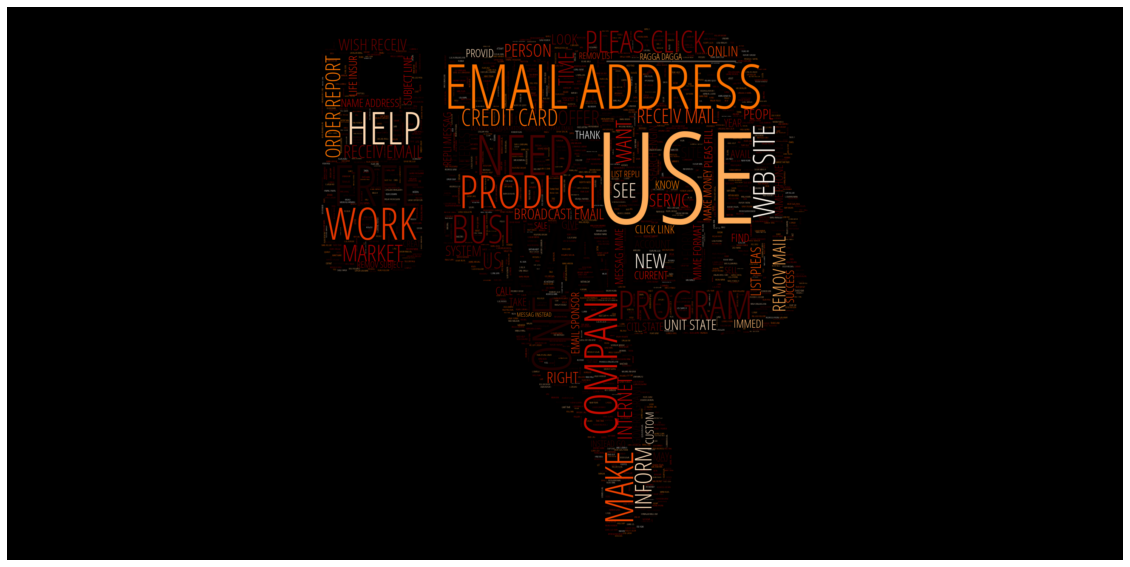

In [48]:
#NOT SPAM EMAILS

icon = Image.open(spamIcon)
imageMask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
imageMask.paste(icon, box=icon)

rgbArray = np.array(imageMask)

spamStr = ' '.join(finalSpamList)

wordCloud = WordCloud(mask=rgbArray, max_words=2000, colormap='gist_heat', font_path=fontWordCloudLight, max_font_size=300)

wordCloud.generate(spamStr.upper())
plt.figure(figsize=(20, 20))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###Generate a Vocabulary and a Dictionary

In [49]:
stemmedNested = data.MESSAGE.apply(cleanMessage)
flatStemmed = [item for sublist in stemmedNested for item in sublist]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [50]:
uniqueWords =  pd.Series(flatStemmed).value_counts()
print('No. of unique words', uniqueWords.shape[0])
uniqueWords.head()

No. of unique words 27247


http     10653
use       5010
list      4851
email     4356
get       4179
dtype: int64

In [51]:
frequentWords = uniqueWords[0:vocabSize]
print('The most common 10 words are:\n', frequentWords[:10])

The most common 10 words are:
 http     10653
use       5010
list      4851
email     4356
get       4179
mail      3979
one       3894
free      3166
time      3086
work      2877
dtype: int64


###Create a Vocabulary DataFame with a wordID

In [52]:
wordID = list(range(0, vocabSize))
vocab = pd.DataFrame({'vocabWords':frequentWords.index.values}, index=wordID)
vocab.index.name = 'wordIDs'
vocab.head()

,vocabWords
wordIDs,
0,http
1,use
2,list
3,email
4,get


###Save the vocab dataframe as a csv file

In [53]:
vocab.to_csv(dataCSV, index_label=vocab.index.name, header=vocab.vocabWords.name)

##Generate Features and a Sparse Matrix

##Creating a DataFrame with one word per column


In [54]:
wordsColumnDF = pd.DataFrame.from_records(stemmedNested.tolist())
wordsColumnDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
0,multipart,messag,mime,format,lose,weight,build,lean,muscl,mass,revers,ravag,age,human,growth,hormon,therapi,lose,weight,build,lean,muscl,mass,revers,ravag,age,remark,discoveri,human,growth,hormon,hgh,chang,way,think,age,weight,lose,weight,build,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,hello,may,seen,busi,ignor,know,mani,time,howev,pleas,take,moment,read,letter,amaz,profit,potenti,busi,final,sunk,work,tool,success,busi,fast,easi,well,within,capabl,ordinari,peopl,know,littl,internet,market,earn,potenti,truli,stagger,make,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,cellular,phone,accessori,wholesal,price,http,hand,free,ear,bud,phone,holster,booster,antenna,phone,case,car,charger,face,plate,low,lithium,ion,batteri,low,http,click,accessori,nokia,motorola,lg,nextel,samsung,qualcomm,ericsson,audiovox,phone,wholesal,price,http,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,copyright,right,reservedif,would,longer,ike,us,contact,feel,havereceiv,email,pleas,k,unsubscrib,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,need,health,insur,addit,featur,largest,select,major,medic,health,plan,lead,compani,servic,also,offer,wide,select,qualiti,dental,plan,obtain,free,instant,quot,comparison,best,avail,price,onlin,applic,knowledg,custom,care,team,help,find,plan,right,would,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5783,mani,good,musician,joke,coupl,favorit,differ,viola,violin,viola,burn,longer,definit,minor,second,two,obo,play,unison,joe,http,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5784,xander,blakley,quot,russian,joke,terrif,book,frenchman,american,russian,get,talk,bout,countri,desir,women,frenchman,say,ah,frenchman,put,hand,around,zee,waist,lover,finger,form,complet,circl,touch,hand,larg,zee,french,woman,waist,slender,american,say,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5785,sure,ask,mail,handl,like,attach,broken,mime,part,attach,treat,one,part,header,bodi,sent,server,without,pars,way,handl,treat,like,regular,mail,break,part,reason,break,break,right,chose,break,might,chang,futur,

##Splitting into a training and a testing dataset

In [55]:
xTrain, xTest, yTrain, yTest = train_test_split(wordsColumnDF, data.CATEGORY, test_size=0.3, random_state=42)

In [56]:
xTrain.index.name = xTest.index.name = 'docID'

##Creating a Sparse Matix for the Training Dataset

In [57]:
wordIndex = pd.Index(vocab.vocabWords)

In [58]:
def makeSparse(df, indexedWords, labels):
    
    nrRows = df.shape[0]
    nrCols = df.shape[1]
    wordSet = set(indexedWords)
    
    dictList = []

    for i in range (nrRows):
        for j in range (nrCols):
            word = df.iat[i, j]
            if word in wordSet:
                docID = df.index[i]
                wordID = indexedWords.get_loc(word)
                category = labels.at[docID]

                item = {'LABEL': category, 'DOC ID': docID, 'OCCURANCE': 1, 'WORD ID': wordID}
                dictList.append(item)

    return pd.DataFrame(dictList)

In [59]:
%%time

sparseTrainDf = makeSparse(xTrain, wordIndex, yTrain)

CPU times: user 10min 38s, sys: 1.36 s, total: 10min 39s
Wall time: 10min 40s


In [60]:
sparseTrainDf

,LABEL,DOC ID,OCCURANCE,WORD ID
0,0,2226,1,109
1,0,2226,1,0
2,0,2226,1,76
3,0,2226,1,222
4,0,2226,1,535
...,...,...,...,...
446465,1,860,1,207
446466,1,860,1,224
446467,1,860,1,494
446468,1,860,1,96


###Combine Occurances with Pandas groupby() method

In [61]:
trainGrouped = sparseTrainDf.groupby(['DOC ID', 'WORD ID', 'LABEL']).sum()
trainGrouped = trainGrouped.reset_index()
trainGrouped

,DOC ID,WORD ID,LABEL,OCCURANCE
0,0,0,1,2
1,0,1,1,1
2,0,2,1,2
3,0,3,1,4
4,0,5,1,3
...,...,...,...,...
264000,5787,1954,0,1
264001,5787,2073,0,1
264002,5787,2114,0,1
264003,5787,2294,0,1


###Save the Training data as .txt file

In [62]:
np.savetxt(trainingDataFile, trainGrouped, fmt='%d')

###Creating a Sparse Matrix for the Testing Dataset

In [63]:
%%time

sparseTestDf = makeSparse(xTest, wordIndex, yTest)

CPU times: user 4min 35s, sys: 565 ms, total: 4min 36s
Wall time: 4min 36s


In [64]:
sparseTestDf

,LABEL,DOC ID,OCCURANCE,WORD ID
0,0,4958,1,114
1,0,4958,1,293
2,0,4958,1,466
3,0,4958,1,60
4,0,4958,1,771
...,...,...,...,...
186401,1,368,1,3
186402,1,368,1,26
186403,1,368,1,57
186404,1,368,1,300


###Combine Occurances with Pandas groupby() method

In [65]:
testGrouped = sparseTestDf.groupby(['DOC ID', 'WORD ID', 'LABEL']).sum()
testGrouped = testGrouped.reset_index()
testGrouped

,DOC ID,WORD ID,LABEL,OCCURANCE
0,8,4,1,2
1,8,7,1,3
2,8,8,1,1
3,8,19,1,1
4,8,24,1,1
...,...,...,...,...
111200,5783,962,0,1
111201,5783,1323,0,1
111202,5783,1635,0,1
111203,5783,1698,0,1


###Saving the Test Dataset as a txt file

In [66]:
np.savetxt(testingDataFile, testGrouped, fmt='%d')